In [1]:
# Necessary imports and setup
%matplotlib widget

import jax
import jax.numpy as jnp
import numpy as np

import sys

# Change to the path to your likelihood installation here!
#sys.path.append('/Users/lennart/Research/SPT3G_JAX_Likelihood')

import candl
import candl.tools
import candl.interface
import candl.plots
import candl.data
import candl.tests

import matplotlib.pyplot as plt

from copy import deepcopy

import sigfig


In [2]:
candl.tests.run_all_tests()

Test passed for ACT DR4 TT/TE/EE (Choi et al. 2020, Aiola et al. 2020):
  (relative difference = 5.3e-07)!
Test passed for ACT DR6 PP (Madhavacheril et al. 2023, Qu et al. 2023, Carron et al. 2023):
  (relative difference = -2.5e-16)!
Test passed for SPT-3G 2018 TT/TE/EE (Balkenhol et al. 2023):
  (relative difference = -1.1e-10)!
Test passed for SPT-3G 2018 PP (Pan et al. 2023):
  (relative difference = 1.9e-06)!


In [3]:
rel_diff = 5.3002647595422e-07


In [4]:
import sigfig

In [14]:
sigfig.round(rel_diff, sigfigs = 2)

5.3e-07

# SPT-3G 2018 TTTEEE

In [3]:
spt3g_like = candl.Like(candl.data.SPT3G_2018_TTTEEE)

Successfully initialised candl likelihood 'SPT-3G 2018 TT/TE/EE (Balkenhol et al. 2023)' (type: <class 'candl.likelihood.Like'>).
Data loaded from '/Users/lennart/.local/lib/python3.10/site-packages/candl/data/SPT3G_2018_TTTEEE/'.
Functional likelihood form: gaussian_beam_detcov
--------------------------------------------------------------------------------
It will analyse the following spectra:

TT 90x90     (35 bins, bin centres spanning ell = 774.5 - 2946.3)
TE 90x90     (44 bins, bin centres spanning ell = 325.8 - 2946.0)
EE 90x90     (44 bins, bin centres spanning ell = 325.2 - 2945.8)
TT 90x150    (35 bins, bin centres spanning ell = 774.5 - 2946.7)
TE 90x150    (44 bins, bin centres spanning ell = 325.8 - 2946.2)
EE 90x150    (44 bins, bin centres spanning ell = 325.1 - 2945.9)
TT 90x220    (35 bins, bin centres spanning ell = 774.5 - 2946.4)
TE 90x220    (44 bins, bin centres spanning ell = 325.8 - 2946.1)
EE 90x220    (44 bins, bin centres spanning ell = 325.1 - 2945.9)
TT 15

In [4]:
chains_base = "/Users/lennart/Research/SPT-3G 2018 TT:TE:EE/Cosmology/Chains/wave_4/lcdm/w_pol_dust/"
chain_steps = np.loadtxt(chains_base + "lcdm_spt3g_ttteee_baseline_1.txt")
data_path = "/Users/lennart/Research/software/CosmoMC/"

chain_pars = ["weight", "logl"]
with open(chains_base + "lcdm_spt3g_ttteee_baseline.paramnames", "r") as f:
    for line in f.readlines():
        chain_pars.append(line.split()[0].replace("*", ""))

all_fortran_logl = []
all_jax_logl = []
for i in range(1):

    # Read in parameter values
    pars_for_like = {}
    for j, par in enumerate(chain_pars):
        if j < 2:
            continue
        pars_for_like[par] = chain_steps[i,j]
        if par == "TT_kSZ_Amp":
            break
    
    # Read Cls
    point_Cls = {}
    for k, spec in enumerate(spt3g_like.spec_order):
        Cls_arr = np.loadtxt(f"{data_path}spotcheck/spot_{i}/unbinned_theory_{spt3g_like.spec_freqs[k][0]}_{spt3g_like.spec_types[k][0]}x{spt3g_like.spec_freqs[k][1]}_{spt3g_like.spec_types[k][1]}.txt")
        point_Cls[spec] = Cls_arr[:,1:]
    
    # Prepare for likelihood
    pars_for_like["TT_tSZ_CIB_Corr_Amp"] = pars_for_like["TT_tSZ_CIB_corr"]
    pars_for_like["TT_CIBClustering_Alpha"] = 0.8
    Cls = {"TT": point_Cls["TT 90x90"][1,:],
           "TE": point_Cls["TE 90x90"][1,:],
           "EE": point_Cls["EE 90x90"][1,:]}
    pars_for_like["Dl"] = Cls

    # Calculate logl
    point_logl = spt3g_like.log_like(pars_for_like)
    point_prior_logl = spt3g_like.prior_logl(pars_for_like)
    point_cal_logl = spt3g_like.priors[-1].log_like(pars_for_like)
    
    # logl match to 0.01
    point_fortran_logl = np.loadtxt(f"{data_path}spotcheck/spot_{i}/logl.txt")
    point_comparison_logl = -(point_logl+point_prior_logl)
    
    all_fortran_logl.append(point_fortran_logl)
    all_jax_logl.append(point_comparison_logl)

all_fortran_logl = np.asarray(all_fortran_logl)
all_jax_logl = np.asarray(all_jax_logl)

In [5]:
(all_jax_logl-all_fortran_logl)/all_fortran_logl

array([-1.05669394e-10])

In [26]:
all_fortran_logl

array([1318.59412997])

In [7]:
point_logl+point_prior_logl

Array(-1318.59412983, dtype=float64)

In [11]:
((point_logl+point_prior_logl) - all_fortran_logl)/all_fortran_logl

Array([-2.], dtype=float64)

In [12]:
all_fortran_logl

array([1318.59412997])

In [13]:
point_logl

Array(-1336.16064295, dtype=float64)

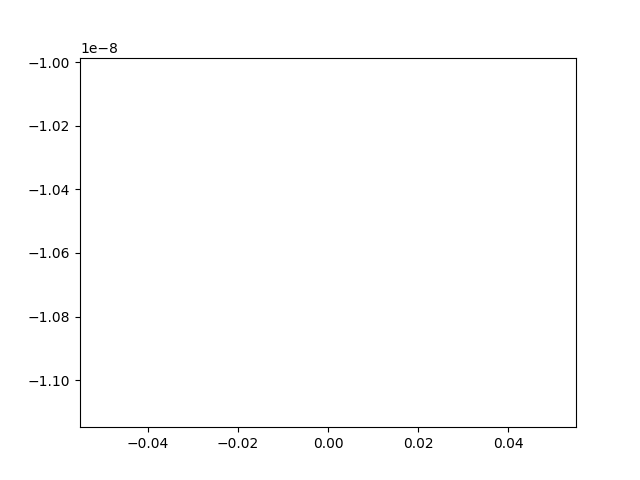

In [15]:
plt.close()

plt.plot(100*(all_jax_logl-all_fortran_logl)/all_fortran_logl)

plt.show()


In [19]:
len(pars_for_like["Dl"]["TT"])

3199

In [25]:
ell = np.arange(2,len(pars_for_like["Dl"]["TT"])+2)
test_spec_save_order = ["ell", "TT", "TE", "EE", "BB", "PP", "KK"]
test_spec_save_arr = np.stack([ell, pars_for_like["Dl"]["TT"], pars_for_like["Dl"]["TE"], pars_for_like["Dl"]["EE"], np.zeros_like(ell), np.zeros_like(ell), np.zeros_like(ell)])
test_spec_save_header = "ell, TT, TE, EE, BB, PP, KK"
#np.savetxt("../candl/tests/SPT3G_2018_TTTEEE_test_spec.txt", test_spec_save_arr.T, header=test_spec_save_header)


In [27]:
pars_for_like

{'omegabh2': 0.02204797,
 'omegach2': 0.1218105,
 'theta': 1.040541,
 'tau': 0.05577727,
 'logA': 3.050983,
 'ns': 0.9534238,
 'Kappa': -0.0002440679,
 'Tcal90': 0.9969211,
 'Tcal150': 0.9943175,
 'Tcal220': 0.9920934,
 'Ecal90': 1.007357,
 'Ecal150': 1.003155,
 'Ecal220': 0.98939,
 'EE_Poisson_90x90': 0.05098635,
 'EE_Poisson_90x150': 0.0136798,
 'EE_Poisson_90x220': 0.02572416,
 'EE_Poisson_150x150': 0.01681153,
 'EE_Poisson_150x220': 0.008015064,
 'EE_Poisson_220x220': 0.07775213,
 'EE_PolGalDust_Amp': 0.05888307,
 'EE_PolGalDust_Alpha': -2.419544,
 'EE_PolGalDust_Beta': 1.443561,
 'TE_PolGalDust_Amp': 0.1541269,
 'TE_PolGalDust_Alpha': -2.441634,
 'TE_PolGalDust_Beta': 1.490916,
 'TT_Poisson_90x90': 53.43998,
 'TT_Poisson_90x150': 18.90332,
 'TT_Poisson_90x220': 8.724569,
 'TT_Poisson_150x150': 18.3131,
 'TT_Poisson_150x220': 33.34119,
 'TT_Poisson_220x220': 79.28012,
 'TT_GalCirrus_Amp': 2.043606,
 'TT_GalCirrus_Alpha': -2.607069,
 'TT_GalCirrus_Beta': 1.506616,
 'TT_CIBClustering

In [3]:
candl.data.data_path

'/Users/lennart/.local/lib/python3.10/site-packages/candl/data'

In [5]:
candl.data.SPT3G_2018_TTTEEE

'/Users/lennart/.local/lib/python3.10/site-packages/candl/data/SPT3G_2018_TTTEEE/SPT3G_2018_TTTEEE.yaml'

In [102]:
test_spec = np.loadtxt(test_dict["test_spectrum"])

# ACT DR6 Lensing

In [27]:
dataset_file_lensing = "../real_data/ACT_DR6_Lens/ACT_DR6_KK_lens_only.yaml"
#dataset_file_lensing = "../real_data/ACT_DR6_Lens/ACT_DR6_KK_lens_and_CMB.yaml"

#dataset_file_lensing = "/Users/lennart/Research/SPT3G_JAX_Likelihood/real_data/ACT_DR6_PP/ACT_lens_only/ACT_DR6_PP_lens_only.yaml"

candl_like = candl.LensLike(dataset_file_lensing)


In [28]:
data_file = "/Users/lennart/Research/software/act_dr6_lenslike/act_dr6_lenslike/data/v1.1/like_corrs/cosmo2017_10K_acc3_lenspotentialCls.dat"
ell, cl_tt, cl_ee, cl_bb, cl_te, cl_pp, cl_tp, cl_ep= np.loadtxt(data_file, unpack=True)



In [29]:
prefac = 2*np.pi/ell/(ell+1.)
cl_kk= cl_pp/4*2*np.pi
cl_bb = cl_bb*prefac
cl_tt = cl_tt*prefac
cl_ee = cl_ee*prefac
cl_te = cl_te*prefac
ell_kk = ell
ell_cmb=ell


In [30]:
import act_dr6_lenslike

lens_only = True
data_dict = act_dr6_lenslike.load_data("act_baseline",
                            lens_only=lens_only,
                            like_corrections=not(lens_only))


In [31]:
chisq=-2*act_dr6_lenslike.generic_lnlike(data_dict,ell_kk,cl_kk,ell_cmb,cl_tt,cl_ee,cl_te,cl_bb,trim_lmax = 2998)
print(chisq)

BINNED CORRECTED THEORY: [2.13549179e-07 1.82124235e-07 1.43431193e-07 1.08337994e-07
 8.07348138e-08 6.04213628e-08 4.53685963e-08 3.39002576e-08
 2.53570454e-08 1.92051294e-08]
DIFF: [ 2.18443990e-08  7.67214603e-11 -6.67816394e-09 -8.33112419e-09
 -4.95420651e-09  1.24612978e-09 -1.45448072e-09  7.01060054e-09
 -4.30818311e-10 -3.62387445e-09]
CINV: [3.95225139e+15 1.04591544e+16 2.09166922e+16 3.42155972e+16
 4.44341697e+16 4.38571466e+16 6.55705037e+16 9.72808272e+16
 1.34914283e+17 1.51351891e+17]
14.057911788739437


In [36]:
cl2dl = ell*(ell+1.0)/(2*np.pi)
ref_spec = {"Dl": {"kk": cl_kk[:3000-2],
                    "pp": cl_pp[:3000-2],
                    "TT": (cl_tt*cl2dl)[:3000-2],
                    "TE": (cl_te*cl2dl)[:3000-2],
                    "EE": (cl_ee*cl2dl)[:3000-2],
                    "BB": (cl_bb*cl2dl)[:3000-2]},
            "Cls": {"kk": cl_kk[:3000-2],
                    "pp": cl_pp[:3000-2],
                    "TT": (cl_tt)[:3000-2],
                    "TE": (cl_te)[:3000-2],
                    "EE": (cl_ee)[:3000-2],
                    "BB": (cl_bb)[:3000-2]}}

my_chisq = candl_like.chi_square(ref_spec)
#chisq = #20.532629573102657

print(f"JAX: {my_chisq}")
print(f"ACT: {chisq}")
print(f"Diff: {my_chisq-chisq}")
print(f"Diff %: {100*(my_chisq-chisq)/chisq}")


JAX: 14.057911788739434
ACT: 14.057911788739437
Diff: -3.552713678800501e-15
Diff %: -2.5271987277984408e-14


In [67]:
test_spec_save_order = ["ell", "TT", "TE", "EE", "BB", "PP", "KK"]
test_spec_save_arr = np.stack([ell[:3000-2], ref_spec["Dl"]["TT"], ref_spec["Dl"]["TE"], ref_spec["Dl"]["EE"], ref_spec["Dl"]["BB"], ref_spec["Dl"]["pp"], ref_spec["Dl"]["kk"]])
test_spec_save_header = "ell, TT, TE, EE, BB, PP, KK"
#np.savetxt("../tests/ACT_DR6_Lens_test_spec.txt", test_spec_save_arr.T, header=test_spec_save_header)


In [64]:
np.shape(test_spec_save_arr)

(7, 2998)

In [54]:
np.shape(test_spec_save_arr)

(7,)

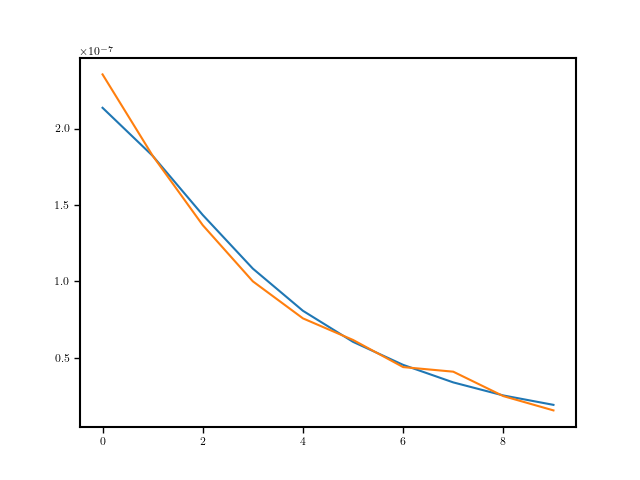

In [34]:
model_specs = candl_like.get_model_specs(ref_spec)

plt.close()

plt.plot(model_specs)
plt.plot(candl_like.data_bandpowers)

plt.show()


In [49]:
cl_pp

array([5.2091e-08, 6.3208e-08, 7.2761e-08, ..., 2.8488e-11, 2.8469e-11,
       2.8450e-11])

In [15]:
candl_like.data_model[0].M_matrices.keys()

dict_keys(['kk', 'TT', 'TE', 'EE', 'BB'])

In [17]:
candl_like.data_model[0].output(ref_spec)

Array([0.00049734, 0.00079367, 0.00102524, 0.0011466 , 0.00125377,
       0.00130074, 0.0011564 , 0.00110635, 0.00075743, 0.000253  ],      dtype=float64)

In [18]:
candl_like.data_model[0].fiducial_correction

Array([2.48731577e-09, 3.45146801e-09, 4.35053184e-09, 5.18231417e-09,
       6.61525577e-09, 8.47167410e-09, 8.46563660e-09, 8.33607787e-09,
       9.32230458e-09, 9.80511515e-09], dtype=float64)

In [25]:
new_ref_specs = deepcopy(ref_spec)
new_ref_specs["Dl"] = new_ref_specs["Cls"]

M_correction = -candl_like.data_model[0].fiducial_correction

# multiply arrays according to length of theory spectra
l_length = len(jnp.block(new_ref_specs["Dl"]["pp"]))

for mode in candl_like.data_model[0].M_matrices.keys():
    M_correction += jnp.dot(
        np.transpose(candl_like.data_model[0].M_matrices[mode][:l_length]),
        jnp.block(new_ref_specs["Dl"][mode]),
            )
    print(mode)
    print(M_correction)

kk
[-1.46594110e-09 -2.33949815e-09 -3.07403884e-09 -3.55276074e-09
 -4.15990331e-09 -4.73870563e-09 -4.36961425e-09 -4.75819465e-09
 -5.39924420e-09 -5.56376419e-09]
TT
[-2.10643770e-10 -3.35882520e-10 -4.58774640e-10 -5.68255358e-10
 -9.94707605e-10 -1.64636757e-09 -1.18259005e-09 -1.93276908e-09
 -3.13387396e-09 -4.28379727e-09]
TE
[ 3.05693732e-10  4.88209433e-10  6.55017630e-10  7.86222115e-10
  7.27312686e-10  5.17921479e-10  9.92760939e-10  5.41591271e-10
 -3.49814748e-10 -1.28316625e-09]
EE
[2.13621364e-10 3.40936704e-10 4.49641197e-10 5.23249602e-10
 5.79229976e-10 5.98296674e-10 5.73981175e-10 5.61895343e-10
 5.56466765e-10 5.51493454e-10]
BB
[2.13621364e-10 3.40936704e-10 4.49641197e-10 5.23249602e-10
 5.79229976e-10 5.98296674e-10 5.73981175e-10 5.61895343e-10
 5.56466765e-10 5.51493454e-10]


In [20]:
M_correction

Array([0.00049734, 0.00079367, 0.00102524, 0.0011466 , 0.00125377,
       0.00130074, 0.0011564 , 0.00110635, 0.00075743, 0.000253  ],      dtype=float64)

In [4]:
import act_dr6_lenslike
print(act_dr6_lenslike.__path__)

['/Users/lennart/Research/software/act_dr6_lenslike/act_dr6_lenslike']


In [ ]:
# TTTEEE (chisq)
# ACT
# diff 0.000152781652673184
# diff %: 5.3002647595422e-05
# ACT cut for Planck
# diff 0.0001446752405342977
# diff %: 6.152569932733205e-05

# Lensing (chisq)
# ACT lensing w/ CMB transformation
# Match supplied chisq to: Diff %: 7.368829997794926e-14

# ACT lensing w/o CMB transformation
# Match supplied chisq to: Diff %: 6.921108017171822e-14


# Lensing

In [7]:
import act_dr6_lenslike as alike

In [8]:
data_file = "/Users/lennart/Research/software/act_dr6_lenslike/act_dr6_lenslike/data/v1.1/like_corrs/cosmo2017_10K_acc3_lenspotentialCls.dat"
ell, cl_tt, cl_ee, cl_bb, cl_te, cl_pp, cl_tp, cl_ep= np.loadtxt(data_file, unpack=True)



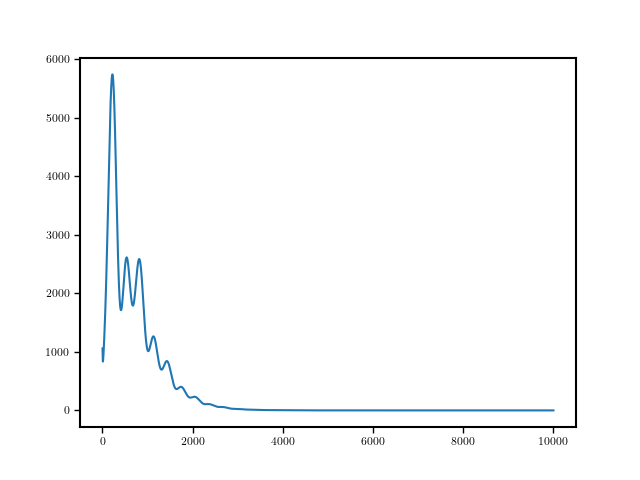

In [9]:
plt.close()

plt.plot(ell, cl_tt)

plt.show()


In [10]:
prefac = 2*np.pi/ell/(ell+1.)
cl_kk= (1.05) * cl_pp/4*2*np.pi
cl_bb = cl_bb*prefac
cl_tt = cl_tt*prefac
cl_ee = cl_ee*prefac
cl_te = cl_te*prefac
ell_kk = ell
ell_cmb=ell


In [14]:
lens_only = False
data_dict = alike.load_data("act_baseline",
                            lens_only=lens_only,
                            like_corrections=not(lens_only))


In [15]:
chisq=-2*alike.generic_lnlike(data_dict,ell_kk,cl_kk,ell_cmb,cl_tt,cl_ee,cl_te,cl_bb,trim_lmax = 2998)


HITTING CORRECTIONS!
Fiducial:  [0.00000000e+00 0.00000000e+00 8.18243515e-08 9.92868942e-08
 1.14292712e-07 1.27308330e-07 1.38646338e-07 1.48614611e-07
 1.57425208e-07 1.65263482e-07]
Curent Theory:  [0.00000000e+00 0.00000000e+00 8.59155690e-08 1.04251239e-07
 1.20007347e-07 1.33673746e-07 1.45578655e-07 1.56045342e-07
 1.65296468e-07 1.73526656e-07]
ells: [   0    1    2 ... 2997 2998 2999]
tt to Norm: [-0.00000000e+00 -0.00000000e+00  8.56158556e-03  2.10847636e-03
  7.55862623e-04  3.35618100e-04  1.71209595e-04  9.63346705e-05
  5.82988862e-05  3.73284727e-05]
tt to N1 CMB: [0.00000000e+00 0.00000000e+00 1.61635149e-13 1.19140648e-12
 2.22117782e-12 3.25094916e-12 4.28072049e-12 5.31049183e-12
 6.34026316e-12 7.37003450e-12]
--------------------
ee to Norm: [-0.00000000e+00 -0.00000000e+00  1.23126351e-02  3.02022176e-03
  1.07983155e-03  4.78342614e-04  2.43596605e-04  1.36861318e-04
  8.27250045e-05  5.29118364e-05]
ee to N1 CMB: [0.00000000e+00 0.00000000e+00 3.58369482e-13 2

In [16]:
chisq

24.106362067408444

In [24]:
list(data_dict.keys())

['include_planck',
 'likelihood_corrections',
 'fiducial_cl_tt',
 'fiducial_cl_te',
 'fiducial_cl_ee',
 'fiducial_cl_bb',
 'fiducial_cl_kk',
 'full_data_binned_clkk_act',
 'data_binned_clkk',
 'full_binmat_act',
 'binmat_act',
 'bcents_act',
 'full_act_cov',
 'dAL_dC',
 'fAL',
 'dN1_kk',
 'dN1_tt',
 'dN1_ee',
 'dN1_bb',
 'dN1_te',
 'cov',
 'cinv']

In [63]:
clkk_fiducial = data_dict['fiducial_cl_kk']
this_theory_cl_kk = np.zeros(3000)
this_theory_cl_kk[2:] = cl_kk[:2998]
ls = np.arange(len(this_theory_cl_kk))

# Put theory spectra into same format
cl_dict = {"tt": cl_tt,
           "te": cl_te,
           "ee": cl_ee,
           "bb": cl_bb,}
for ky in list(cl_dict.keys()):
    arr = np.zeros(3000)
    arr[2:] = cl_dict[ky][:2998]
    cl_dict[ky] = arr

# N1 KK correction
N1_kk_corr = data_dict[f'dN1_kk'] @ (this_theory_cl_kk-clkk_fiducial)
SPT_N1_M_mat = data_dict["binmat_act"] @ data_dict[f'dN1_kk']
SPT_N1_M_mat_sub = SPT_N1_M_mat @ clkk_fiducial
SPT_N1_kk_corr = SPT_N1_M_mat @ this_theory_cl_kk# - SPT_N1_M_mat_sub

# Norm corr
fid_norm = data_dict[f'fAL']
safe_fid_norm = deepcopy(fid_norm)
safe_fid_norm[:2] = 1

# Prep SPT
SPT_total_fiducial_correction = SPT_N1_M_mat_sub
SPT_total_fiducial_correction_by_spec = {"kk": SPT_N1_M_mat_sub}
SPT_norm_corr_M_mat = {}
SPT_norm_corr_M_mat_sub = {}
dNorm = data_dict[f'dAL_dC']
for i, s in enumerate(['tt','ee','bb','te']):
    
    # Norm Corr
    tiled_corr = np.tile(clkk_fiducial, (3000, 1)).T
    tiled_fid_norm = np.tile(safe_fid_norm, (3000, 1)).T
    this_mat = - 2 * dNorm[i] * tiled_corr / tiled_fid_norm
    this_mat = data_dict["binmat_act"] @ this_mat
    
    # N1 CMB
    this_mat += data_dict["binmat_act"] @ data_dict[f'dN1_{s}']

    SPT_norm_corr_M_mat[s] = this_mat
    SPT_norm_corr_M_mat_sub[s] = this_mat @ data_dict[f'fiducial_cl_{s}']
    SPT_total_fiducial_correction += SPT_norm_corr_M_mat_sub[s]
    SPT_total_fiducial_correction_by_spec[s] = SPT_norm_corr_M_mat_sub[s]

norm_corr = 0
spt_norm_corr = 0
for i, s in enumerate(['tt','ee','bb','te']):
    # ACT way
    cldiff = (cl_dict[s]-data_dict[f'fiducial_cl_{s}'])
    c = - 2. * (dNorm[i] @ cldiff)
    c[2:] /= fid_norm[2:]
    norm_corr += c
    
    # SPT way
    spt_norm_corr += SPT_norm_corr_M_mat[s] @ cl_dict[s]# - SPT_norm_corr_M_mat_sub[s]

# N1 CMB corr
N1_cmb_corr = 0
for i, s in enumerate(['tt','ee','bb','te']):
    cldiff = (cl_dict[s]-data_dict[f'fiducial_cl_{s}'])
    N1_cmb_corr += (data_dict[f'dN1_{s}']@cldiff)

# Fully corrected
fully_corrected = this_theory_cl_kk + norm_corr * clkk_fiducial + N1_kk_corr + N1_cmb_corr
fully_corrected_binned = data_dict["binmat_act"] @ fully_corrected

#spt_fully_corrected = this_theory_cl_kk + spt_norm_corr + N1_kk_corr + N1_cmb_corr
spt_binned_theory = data_dict["binmat_act"] @ this_theory_cl_kk
spt_fully_corrected_binned = spt_binned_theory
spt_fully_corrected_binned += spt_norm_corr
spt_fully_corrected_binned += SPT_N1_kk_corr
spt_fully_corrected_binned -= SPT_total_fiducial_correction
#for i, s in enumerate(['tt','ee','bb','te','kk']):
#    spt_fully_corrected_binned -= SPT_total_fiducial_correction_by_spec[s]


In [64]:
fully_corrected_binned

array([2.24491328e-07, 1.91626982e-07, 1.51116218e-07, 1.14359621e-07,
       8.54735521e-08, 6.42273760e-08, 4.84158084e-08, 3.63360600e-08,
       2.73775174e-08, 2.09289468e-08])

In [65]:
spt_fully_corrected_binned

array([2.24491328e-07, 1.91626982e-07, 1.51116218e-07, 1.14359621e-07,
       8.54735521e-08, 6.42273760e-08, 4.84158084e-08, 3.63360600e-08,
       2.73775174e-08, 2.09289468e-08])

In [67]:
# Save SPT matrices out - crop to ell = 2!
base_path = "real_data/ACT_DR6_PP/ACT_lens_and_CMB/lens_delta_windows_phicmb/"

my_spec_order = ["TT", "TE", "EE", "BB", "PP"]

for b in range(10):
    
    #if b == 0:
    #    fid_spec_file = np.zeros((len(my_spec_order)+1, 2998))
    #    fid_spec_file[0,:] = ls[2:]
    
    this_mat = np.zeros((len(my_spec_order)+1, 2998))
    this_mat[0,:] = ls[2:]    
    for i, s in enumerate(['tt','ee','bb','te']):
        for j, spec in enumerate(my_spec_order):
            if s.upper() == spec:
                this_mat[j+1,:] = SPT_norm_corr_M_mat[s][b,2:]
                
                #if b == 0:
                #    fid_spec_file[j+1,:] = data_dict[f'fiducial_cl_{s}'][2:]
 
    this_mat[-1,:] = SPT_N1_M_mat[b,2:]
    #if b == 0:
    #    fid_spec_file[j+1,:] = clkk_fiducial[2:]
    
    # Save M amtrix
    np.savetxt(f"{base_path}window{b+1}.txt", this_mat.T)

# Fiducial correction term
np.savetxt(f"{base_path}fiducial_correction.txt", SPT_total_fiducial_correction)


In [22]:
#dataset_file_lensing = "/Users/lennart/Research/SPT3G_JAX_Likelihood/real_data/ACT_DR6_PP/ACT_lens_and_CMB/ACT_DR6_PP_lens_and_CMB.yaml"
dataset_file_lensing = "/Users/lennart/Research/SPT3G_JAX_Likelihood/real_data/ACT_DR6_PP/ACT_lens_only/ACT_DR6_PP_lens_only.yaml"
spt3g_like = spt3g_jax.SPT3GLensLike(dataset_file_lensing)


In [23]:
cl2dl = ell*(ell+1.0)/(2*np.pi)
ref_spec = {"Dl": {"kk": cl_kk[:3000-2],
                    "pp": cl_pp[:3000-2],
                    "TT": (cl_tt*cl2dl)[:3000-2],
                    "TE": (cl_te*cl2dl)[:3000-2],
                    "EE": (cl_ee*cl2dl)[:3000-2],
                    "BB": (cl_bb*cl2dl)[:3000-2]},
            "Cls": {"kk": cl_kk[:3000-2],
                    "pp": cl_pp[:3000-2],
                    "TT": (cl_tt)[:3000-2],
                    "TE": (cl_te)[:3000-2],
                    "EE": (cl_ee)[:3000-2],
                    "BB": (cl_bb)[:3000-2]}}

my_chisq = spt3g_like.chi_square(ref_spec)

print(f"JAX: {my_chisq}")
print(f"ACT: {chisq}")
print(f"Diff: {my_chisq-chisq}")
print(f"Diff %: {100*(my_chisq-chisq)/chisq}")


JAX: 20.53262957310267
ACT: 20.532629573102657
Diff: 1.4210854715202004e-14
Diff %: 6.921108017171822e-14


In [ ]:
# ACT lensing w/ CMB transformation
# Match supplied chisq to: Diff %: 7.368829997794926e-14

# ACT lensing w/o CMB transformation
# Match supplied chisq to: Diff %: 6.921108017171822e-14


In [25]:
# Save data products
dsadsasdas
np.savetxt("real_data/ACT_DR6_PP/ACT_lens_and_CMB/ACT_DR6_pp_bdp.txt",
           data_dict['data_binned_clkk'])

# Includes Hartlap factor
np.savetxt("real_data/ACT_DR6_PP/ACT_lens_and_CMB/ACT_DR6_pp_cov.txt",
           np.linalg.inv(data_dict['cinv']))

this_ells = np.arange(0, 3000)
this_windows = np.zeros((3000-2, 11))
this_windows[:,0] = this_ells[2:]
this_windows[:,1:] = data_dict['binmat_act'][:,2:].T

np.savetxt("real_data/ACT_DR6_PP/ACT_lens_and_CMB/windows/pp_window_functions.txt",
           this_windows)


## Initialise Own Like

In [10]:
dataset_file_lensing = "/Users/lennart/Research/SPT3G_JAX_Likelihood/real_data/ACT_DR6_PP/lens_only/ACT_DR6_PP_lens_only.yaml"
spt3g_like = spt3g_jax.SPT3GLensLike(dataset_file_lensing)


In [11]:
ref_spec = {"kk": cl_kk[:3000-2],
            "L": ell_kk[:3000-2]}
my_chisq = spt3g_like.chi_square({"Dls": ref_spec})

print(f"JAX: {my_chisq}")
print(f"ACT: {chisq}")
print(f"Diff: {my_chisq-chisq}")
print(f"Diff %: {100*(my_chisq-chisq)/chisq}")


JAX: 14.057911788739434
ACT: 14.057911788739437
Diff: -3.552713678800501e-15
Diff %: -2.5271987277984408e-14


In [12]:
fid_pars = {'H0': 67.37,
            'ombh2': 0.02233,
            'omch2': 0.1198,
            'logA': 3.043,
            'ns': 0.9652,
            'tau': 0.054}

cp_emulator_filenames = {"pp": "cmb_pp",
                         "TT": "cmb_spt_TT_NN"}
theory_calc = spt3g_interface.CobayaTheoryCosmoPowerJAXLensing(cp_emulator_filenames)


In [13]:
pars_for_th = {"params": fid_pars}
theory_calc.calculate(pars_for_th)

In [14]:
pars_for_th["Cl"]["pp"]

Array([8.77213209e-09, 2.67007416e-09, 1.10791347e-09, ...,
       1.41522138e-22, 1.41170098e-22, 1.40819031e-22], dtype=float64)

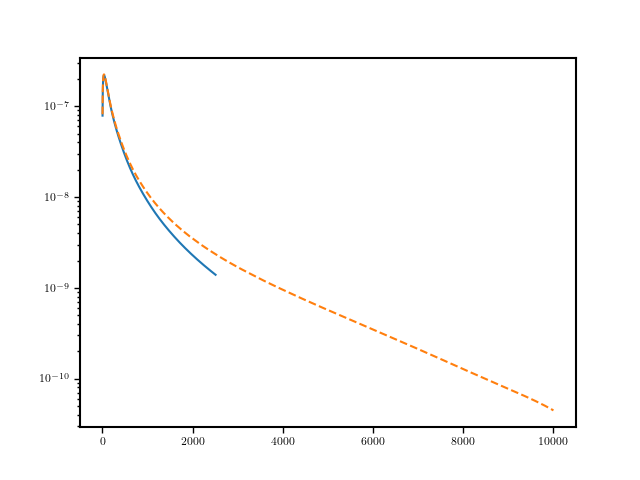

In [15]:
plt.close()

plt.plot(pars_for_th["Dl"]["L"], pars_for_th["Dl"]["kk"])
plt.plot(ell_kk, cl_kk, ls="--")

plt.yscale("log")

plt.show()


In [16]:
pars2chisq = spt3g_tools.get_params_to_chi_square_func(spt3g_like,
                                                      spt3g_interface.get_cobaya_pars_to_theory_specs_func(theory_calc))


In [20]:
pars2chisq(fid_pars)

TypeError: Incompatible shapes for dot: got (2507,) and (2998, 10).

(2998, 10)

In [23]:
ref_spec["L"]

array([2.000e+00, 3.000e+00, 4.000e+00, ..., 2.997e+03, 2.998e+03,
       2.999e+03])

In [26]:
2*spt3g_like.log_like({"Dls": ref_spec})

Array(-14.05791179, dtype=float64)

In [29]:
my_chisq

Array(14.05791179, dtype=float64)

In [ ]:
#np.savetxt(d['data_binned_clkk'], "my_ACT_DR6_pp_bdp.txt")


In [31]:
data_dict["data_binned_clkk"]

array([2.35393578e-07, 1.82200956e-07, 1.36753029e-07, 1.00006870e-07,
       7.57806073e-08, 6.16674925e-08, 4.39141156e-08, 4.09108581e-08,
       2.49262271e-08, 1.55812549e-08])

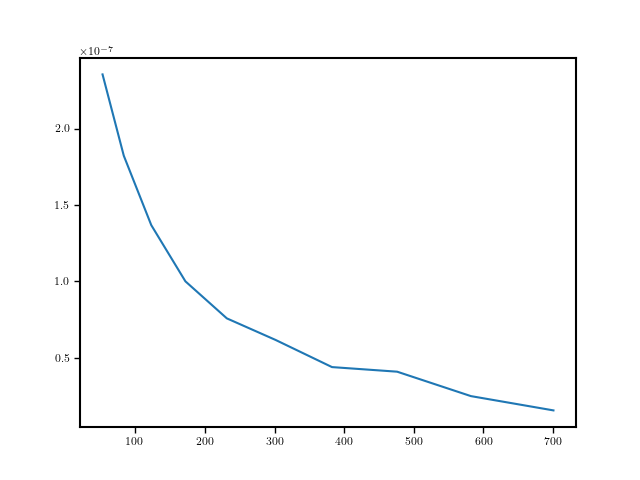

In [34]:
l = data_dict["bcents_act"][2:-6]

plt.close()

plt.plot(l, data_dict["data_binned_clkk"])

plt.show()


In [35]:
len(data_dict["data_binned_clkk"])

10

In [38]:
np.shape(data_dict['binmat_act'])

(10, 3000)

In [ ]:
data_dict['binmat_act']

In [39]:
np.shape(data_dict['full_binmat_act'])

(18, 3000)

# PRIMARY CMB

# Convert Files

## Covariance

In [65]:
nbin = 260
f = FortranFile("real_data/ACT_DR4_CMB_only/actpollite_python_dr4.01/pyactlike/data/c_matrix_ap.dat", "r")
cov = f.read_reals(dtype=float).reshape((nbin, nbin))
for i_index in range(nbin):
    for j_index in range(i_index, nbin):
        cov[i_index, j_index] = cov[j_index, i_index]

#cl2dl = bval*(bval+1)/(2*np.pi)
#cl2dl = spt3g_like.effective_ells*(spt3g_like.effective_ells+1)/(2*np.pi)
cov /= np.outer(cl2dl_vec, cl2dl_vec)


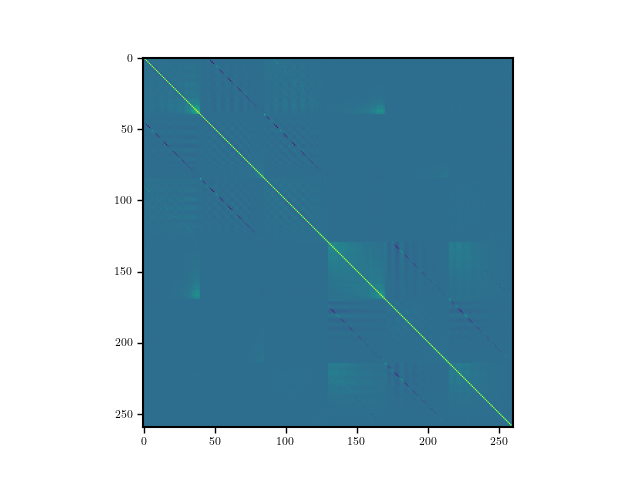

In [37]:
plt.close()

plt.imshow(cov/np.sqrt(np.outer(np.diag(cov), np.diag(cov))))

plt.show()


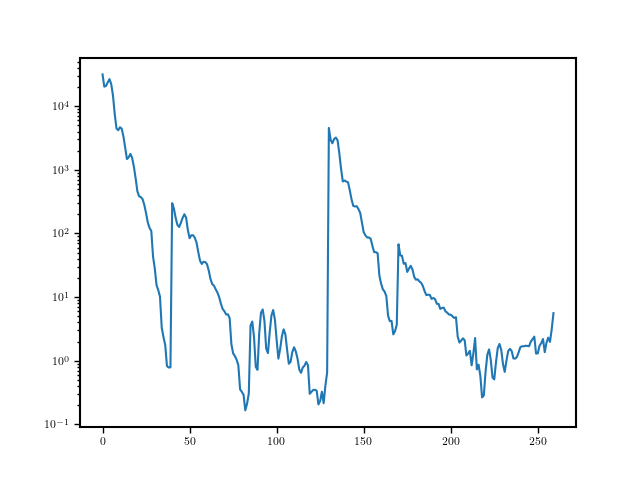

In [66]:
plt.close()

plt.plot(np.diag(cov))

plt.yscale("log")

plt.show()


In [67]:
#np.savetxt("real_data/ACT_DR4_CMB_only/ACT_DR4_CMB_only_cov.txt", cov)


## Band Powers

In [68]:
bval, X_data, X_sig = np.genfromtxt("/Users/lennart/Research/SPT3G_JAX_Likelihood/real_data/ACT_DR4_CMB_only/actpollite_python_dr4.01/pyactlike/data/cl_cmb_ap.dat", max_rows=260, delimiter=None, unpack=True)


In [69]:
# Pretend 90GHz = deep, 150Ghz = wide
Nbins = {"TT": 40,
         "TE": 45,
         "EE": 45}

N_start = {"TT 90x90": 0,
           "TE 90x90": 40,
           "EE 90x90": 85,
           "TT 150x150": 85+45,
           "TE 150x150": 85+45+40,
           "EE 150x150": 85+45+85}


In [70]:
ACT_specs = {}
ACT_ells = {}
for spec in list(N_start.keys()):
    ACT_ells[spec] = bval[N_start[spec]:N_start[spec]+Nbins[spec[:2]]]
    ACT_specs[spec] = X_data[N_start[spec]:N_start[spec]+Nbins[spec[:2]]]
    #ACT_specs[spec] *= spec_conv_binned[N_start[spec]:N_start[spec]+Nbins[spec[:2]]]#cl2dl[N_start[spec]:N_start[spec]+Nbins[spec[:2]]]#ACT_ells[spec]*(ACT_ells[spec]+1)/(2*np.pi)
    #ACT_specs[spec] *= ACT_ells[spec]*(ACT_ells[spec]+1)/(2*np.pi)


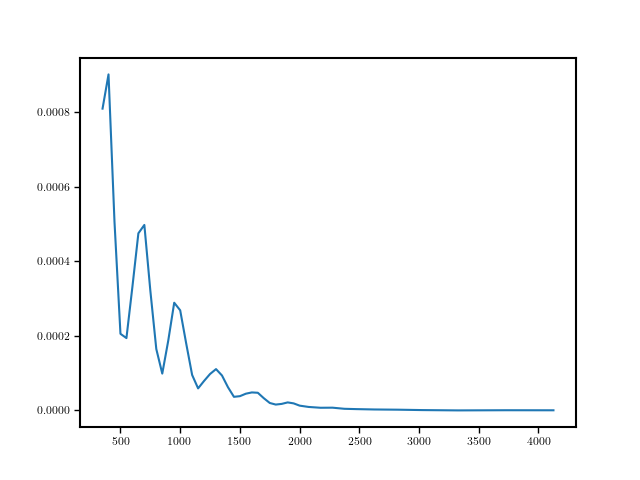

In [71]:
spec = "EE 90x90"

plt.close()

plt.plot(ACT_ells[spec], ACT_specs[spec])

plt.show()


In [72]:
spec_order = ["TT 90x90", "TE 90x90", "EE 90x90", "TT 150x150", "TE 150x150", "EE 150x150"]
spec_vec = []
for spec in spec_order:
    spec_vec += list(ACT_specs[spec])
spec_vec = np.asarray(spec_vec)/cl2dl_vec


In [73]:
#np.savetxt("real_data/ACT_DR4_CMB_only/ACT_DR4_CMB_only_bdp.txt", spec_vec)

## Window Functions

In [196]:
windows_deep_raw = np.load("/Users/lennart/Research/SPT3G_JAX_Likelihood/real_data/ACT_DR4_CMB_only/actpollite_python_dr4.01/pyactlike/data/coadd_bpwf_15mJy_191127_lmin2.npz")["bpwf"]
windows_wide_raw = np.load("/Users/lennart/Research/SPT3G_JAX_Likelihood/real_data/ACT_DR4_CMB_only/actpollite_python_dr4.01/pyactlike/data/coadd_bpwf_100mJy_191127_lmin2.npz")["bpwf"]


In [197]:
windows_deep = np.zeros((520, 7925))
windows_deep[:520, 1:7925] = windows_deep_raw[:520, :7925]

windows_wide = np.zeros((520, 7925))
windows_wide[:520, 1:7925] = windows_wide_raw[:520, :7925]


In [198]:
bmax = 52
lmax_win = 7925
windows_dict = {"TT 90x90": windows_deep[2 * bmax : 3 * bmax, 1:lmax_win][5:45,:],
                "TE 90x90": windows_deep[6 * bmax : 7 * bmax, 1:lmax_win][:45,:],
                "EE 90x90": windows_deep[9 * bmax : 10 * bmax, 1:lmax_win][:45,:],
                "TT 150x150": windows_wide[2 * bmax : 3 * bmax, 1:lmax_win][5:45,:],
                "TE 150x150": windows_wide[6 * bmax : 7 * bmax, 1:lmax_win][:45,:],
                "EE 150x150": windows_wide[9 * bmax : 10 * bmax, 1:lmax_win][:45,:]}

l_list = np.array(range(2, 5000 + 1))
conv_vec = np.zeros(lmax_win)
conv_vec[1 : 5000] = 2.0 * np.pi / l_list / (l_list + 1.0)
#conv_vec[1 : 5000] =  l_list * (l_list + 1.0) / 2.0 / np.pi
cl2dl = conv_vec[1:lmax_win]

#ell = np.arange(2, 5000+1)
#ell = np.asarray(list(ell) + (lmax_win-len(ell)-1)*[0])
#cl2dl = (ell*(ell+1)) / (2*np.pi)
#cl2dl = np.zeros(lmax_win-1)
#cl2dl[:4999] = (2*np.pi)/(ell*(ell+1))

cl_conv_fac = {"TT 90x90": windows_deep[2 * bmax : 3 * bmax, 1:lmax_win] @ cl2dl,
                "TE 90x90": windows_deep[6 * bmax : 7 * bmax, 1:lmax_win] @ cl2dl,
                "EE 90x90": windows_deep[9 * bmax : 10 * bmax, 1:lmax_win] @ cl2dl,
                "TT 150x150": windows_wide[2 * bmax : 3 * bmax, 1:lmax_win] @ cl2dl,
                "TE 150x150": windows_wide[6 * bmax : 7 * bmax, 1:lmax_win] @ cl2dl,
                "EE 150x150": windows_wide[9 * bmax : 10 * bmax, 1:lmax_win] @ cl2dl}
cl2dl_vec = []
spec_order = ["TT 90x90", "TE 90x90", "EE 90x90", "TT 150x150", "TE 150x150", "EE 150x150"]
for spec in spec_order:
    if spec[:2] == "TT":
        cl2dl_vec += list(cl_conv_fac[spec][5:45])
    else:
        cl2dl_vec += list(cl_conv_fac[spec][:45])
cl2dl_vec = np.asarray(cl2dl_vec)


In [199]:
cl_conv_fac["TE 150x150"]

array([ 5.12595068e-05,  3.92267587e-05,  3.09858430e-05,  2.50949984e-05,
        2.07382278e-05,  1.74254119e-05,  1.48476882e-05,  1.28025521e-05,
        1.11527387e-05,  9.80252819e-06,  8.68351812e-06,  7.74577318e-06,
        6.95214888e-06,  6.27455152e-06,  5.69141477e-06,  5.18596052e-06,
        4.74497749e-06,  4.35794833e-06,  4.01641633e-06,  3.71351917e-06,
        3.44364132e-06,  3.20215175e-06,  2.98520380e-06,  2.78958101e-06,
        2.61257713e-06,  2.45190203e-06,  2.30560716e-06,  2.17202622e-06,
        2.04972744e-06,  1.93747512e-06,  1.83419819e-06,  1.73896464e-06,
        1.65096036e-06,  1.56947169e-06,  1.45873757e-06,  1.32767399e-06,
        1.21351458e-06,  1.11347216e-06,  1.02531126e-06,  9.12474365e-07,
        7.87734208e-07,  6.86936486e-07,  5.70044581e-07,  4.53887232e-07,
        3.69953091e-07,  3.08299867e-07,  1.82460948e-07, -1.71822150e-09,
       -6.44551635e-12, -5.50723348e-13, -3.55693964e-13, -2.73712727e-15])

In [53]:
cl2dl_vec[:40]

array([1.74254119e-05, 1.48476882e-05, 1.28025521e-05, 1.11527387e-05,
       9.80252819e-06, 8.68351812e-06, 7.74577319e-06, 6.95214888e-06,
       6.27455153e-06, 5.69141477e-06, 5.18596053e-06, 4.74497749e-06,
       4.35794833e-06, 4.01641633e-06, 3.71351917e-06, 3.44364132e-06,
       3.20215175e-06, 2.98520380e-06, 2.78958101e-06, 2.61257714e-06,
       2.45190204e-06, 2.30560717e-06, 2.17202622e-06, 2.04972745e-06,
       1.93747512e-06, 1.83419820e-06, 1.73896465e-06, 1.65096037e-06,
       1.56947170e-06, 1.45873757e-06, 1.32767400e-06, 1.21351459e-06,
       1.11347217e-06, 1.02531127e-06, 9.12474380e-07, 7.87734298e-07,
       6.86936425e-07, 5.70045800e-07, 4.53889007e-07, 3.69969771e-07])

In [37]:
13*4

52

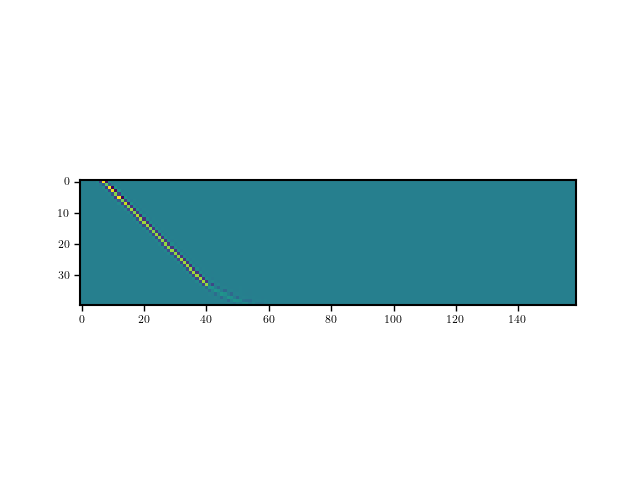

In [65]:
plt.close()

plt.imshow(windows_dict["TT 90x90"][:,::50]-windows_dict["TT 150x150"][:,::50])

plt.show()


In [210]:
np.shape(np.tile(cl2dl, (52, 1)))

(52, 7924)

In [293]:
ell_column = np.arange(2, 7924+2)
spec_order = ["TT 90x90", "TE 90x90", "EE 90x90", "TT 150x150", "TE 150x150", "EE 150x150"]
for spec in spec_order:
    this_window = np.zeros([np.shape(windows_dict[spec])[0]+1, 7924])
    this_window[0,:] = ell_column
    
    window_cl_dl_fac = 1
    if spec[:2] == "TT":
        window_cl_dl_fac = np.tile(cl2dl, (40, 1)) / np.tile(cl_conv_fac[spec][5:45], (7924, 1)).T
    else:
        window_cl_dl_fac = np.tile(cl2dl, (45, 1)) / np.tile(cl_conv_fac[spec][:45], (7924, 1)).T
    
    this_window[1:,:] = windows_dict[spec] * window_cl_dl_fac# * np.tile(cl2dl, (52, 1))[52-np.shape(windows_dict[spec])[0]:]
    np.savetxt(f"real_data/ACT_DR4_CMB_only/windows/{spec.replace(' ', '_')}_window_functions.txt", this_window.T)


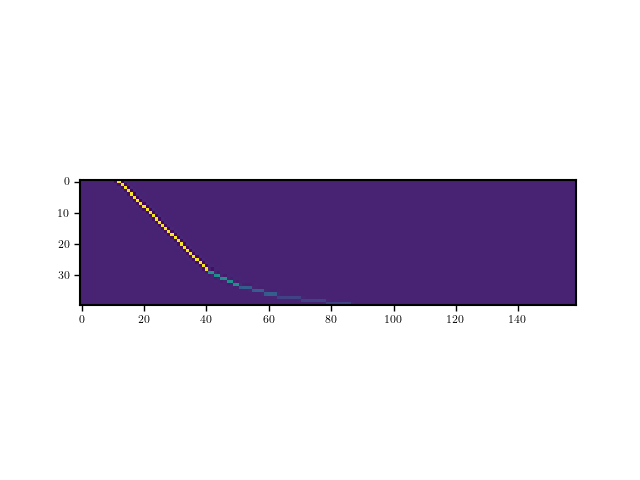

In [203]:
plt.close()

plt.imshow(windows_dict["TT 90x90"][:,::50])

plt.show()

# Initialise the Likelihood

In [13]:
# Here we initialise the likelihood by pointing it to the data set .yaml file
# This file in turn contains all the necessary info, e.g. the spectra we are 
# fitting, the band power file, the covariance file, information on the priors, etc.
dataset_file = "../../real_data/ACT_DR4_CMB_only/ACT_DR4_CMB_only.yaml"
spt3g_like = candl.Like(candl.data.ACT_DR4_TTTEEE)


Successfully initialised candl likelihood 'ACT DR4 TT/TE/EE (Choi et al. 2020, Aiola et al. 2020)' (type: <class 'candl.likelihood.Like'>).
Data loaded from '/Users/lennart/.local/lib/python3.10/site-packages/candl/data/ACT_DR4_CMB_only/'.
Functional likelihood form: gaussian
--------------------------------------------------------------------------------
It will analyse the following spectra:

TT dxd       (40 bins, bin centres spanning ell = 600.3 - 4123.0)
TE dxd       (45 bins, bin centres spanning ell = 350.5 - 4123.0)
EE dxd       (45 bins, bin centres spanning ell = 350.3 - 4122.9)
TT wxw       (40 bins, bin centres spanning ell = 600.4 - 4122.3)
TE wxw       (45 bins, bin centres spanning ell = 350.5 - 4122.4)
EE wxw       (45 bins, bin centres spanning ell = 350.4 - 4122.4)
--------------------------------------------------------------------------------
A data model consisting of 1 transformations has been initialised.
The following transformations will be applied to the theor

In [21]:
candl.data.ACT_DR4_TTTEEE

'/Users/lennart/.local/lib/python3.10/site-packages/candl/data/ACT_DR4_CMB_only/ACT_DR4_CMB_only.yaml'

# Plot the Band Powers

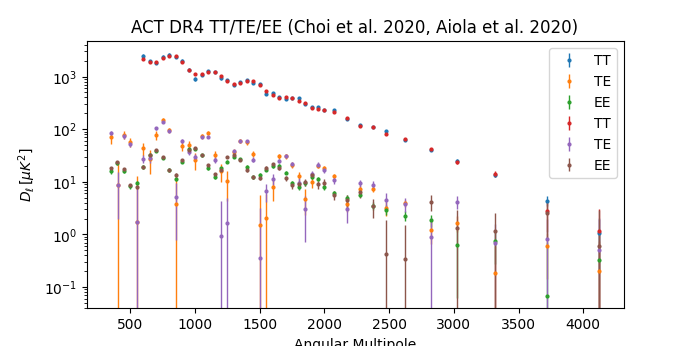

In [14]:
plt.close()

fig = plt.gcf()
fig.set_size_inches(2*3.464, 1*3.464)

for i, spec in enumerate(spt3g_like.spec_order):
    
    # Grab plotting data
    ells_to_plot = spt3g_like.effective_ells[spt3g_like.bins_start_ix[i]:spt3g_like.bins_stop_ix[i]]
    bandpowers_to_plot = spt3g_like.data_bandpowers[spt3g_like.bins_start_ix[i]:spt3g_like.bins_stop_ix[i]]
    error_bars_to_plot = np.sqrt(np.diag(spt3g_like.covariance)[spt3g_like.bins_start_ix[i]:spt3g_like.bins_stop_ix[i]])
    
    # Plot
    plt.errorbar(ells_to_plot,
                 abs(bandpowers_to_plot),
                 error_bars_to_plot,
                 lw=0,
                 ms=2,
                 marker="o",
                 label=spec[:2],
                 elinewidth=1)

plt.yscale("log")
plt.legend()

plt.xlabel("Angular Multipole")
plt.ylabel(r"$D_\ell \, [ \mu K^2 ]$")
plt.title(spt3g_like.name)

plt.show()


# Official Tests

In [15]:
example_spec_file =  "/Users/lennart/Research/SPT3G_JAX_Likelihood/real_data/ACT_DR4_CMB_only/actpollite_python_dr4.01/pyactlike/data/bf_ACTPol_WMAP_lcdm.minimum.theory_cl"
tt_lmax = 5000
ell, dell_tt, dell_te, dell_ee = np.genfromtxt(
    example_spec_file,
    delimiter=None,
    unpack=True,
    max_rows=tt_lmax - 1,
    usecols=(0, 1, 2, 3))

example_spec = {"ell": ell, "TT": dell_tt, "TE": dell_te, "EE": dell_ee}
for ky in list(example_spec.keys()):
    if ky == "ell":
        example_spec[ky] = np.arange(2, spt3g_like.N_ell_bins_theory+2)
    else:
        full_spec = np.zeros(spt3g_like.N_ell_bins_theory)
        full_spec[:tt_lmax-1] = example_spec[ky]#2*np.pi*example_spec[ky]/(ell*(ell+1))
        example_spec[ky] = full_spec


In [17]:
pars_for_like

{'Dl': {'ell': array([   2,    3,    4, ..., 7923, 7924, 7925]),
  'TT': array([1009.6 ,  956.5 ,  904.94, ...,    0.  ,    0.  ,    0.  ]),
  'TE': array([2.7002, 3.1242, 3.0087, ..., 0.    , 0.    , 0.    ]),
  'EE': array([0.034205, 0.047079, 0.043978, ..., 0.      , 0.      , 0.      ])},
 'yp': 1.003}

In [20]:
test_spec_save_order = ["ell", "TT", "TE", "EE", "BB", "PP", "KK"]
test_spec_save_arr = np.stack([pars_for_like["Dl"]["ell"], pars_for_like["Dl"]["TT"], pars_for_like["Dl"]["TE"], pars_for_like["Dl"]["EE"], np.zeros(np.shape(pars_for_like["Dl"]["ell"])), np.zeros(np.shape(pars_for_like["Dl"]["ell"])), np.zeros(np.shape(pars_for_like["Dl"]["ell"]))])
test_spec_save_header = "ell, TT, TE, EE, BB, PP, KK"
#np.savetxt("../candl/tests/ACT_DR4_TTTEEE_test_spec.txt", test_spec_save_arr.T, header=test_spec_save_header)


In [16]:
pars_for_like = {"Dl": example_spec, "yp": 1.003}
chisq = spt3g_like.chi_square(pars_for_like)
#official_chisq = 235.146031846935# ACT cut for Planck
official_chisq = 288.252869629064# ACT

print(f"JAX: {chisq}")
print(f"ACT: {official_chisq}")
print(f"Diff: {chisq-official_chisq}")
print(f"Diff %: {100*(chisq-official_chisq)/official_chisq}")

# ACT
# diff 0.000152781652673184
# diff %: 5.3002647595422e-05
# ACT cut for Planck
# diff 0.0001446752405342977
# diff %: 6.152569932733205e-05


JAX: 288.25302241071665
ACT: 288.252869629064
Diff: 0.000152781652673184
Diff %: 5.3002647595422e-05


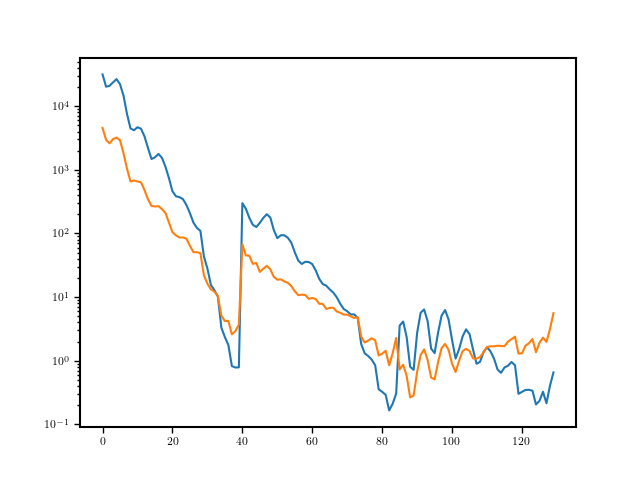

In [17]:
plt.close()

plt.plot(np.diag(spt3g_like.covariance)[:130])
plt.plot(np.diag(spt3g_like.covariance)[130:])

plt.yscale("log")

plt.show()


In [9]:
len(np.diag(spt3g_like.covariance))

260

In [5]:
bmin=24
TTmsk = (bmin)*[False]+(40-bmin)*[True]+(2*45)*[True]
TTmsk = TTmsk + TTmsk
print(TTmsk)


[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, Tru

In [7]:
#np.savetxt("./real_data/ACT_DR4_CMB_only/mask_ACT_DR4_for_Planck.txt", TTmsk)

In [307]:
np.arange(24)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [298]:
chisq

Array(288.25302241, dtype=float64)

In [220]:
modified_theory_Cls = spt3g_like.get_model_specs(pars_for_like)
binned_theory_Cls = spt3g_like.bin_model_specs(modified_theory_Cls)
delta_bdp = spt3g_like.data_bandpowers - binned_theory_Cls


In [221]:
(spt3g_like.data_bandpowers*cl2dl_vec)[0]

Array(0.04356246, dtype=float64)

In [222]:
(modified_theory_Cls[0]*cl2dl[0])

Array(1057.25064769, dtype=float64)

In [223]:
(binned_theory_Cls*cl2dl_vec)[0]

Array(0.0391574, dtype=float64)

In [224]:
(delta_bdp*cl2dl_vec)[0]

Array(0.00440506, dtype=float64)

In [225]:
windows_deep[2 * bmax : 3 * bmax, 1:lmax_win][0,0]

3.2265368598882327e-07

In [231]:
((windows_deep[2 * bmax : 3 * bmax, 1:lmax_win] @ modified_theory_Cls[:7924])[5]*cl2dl_vec[0])

Array(0.0391574, dtype=float64)

In [227]:
((windows_deep[2 * bmax : 3 * bmax, 1:lmax_win] @ (modified_theory_Cls[:7924]*cl2dl))[5])

Array(0.03905299, dtype=float64)

In [228]:
M_mat = windows_deep[2 * bmax : 3 * bmax, 1:lmax_win] * np.tile(cl2dl, (52, 1))

In [229]:
(M_mat @ modified_theory_Cls[:7924])[5]

Array(0.03905299, dtype=float64)

In [244]:
long_l_list = np.array(range(2, lmax_win + 1))
long_cl_conv = np.zeros(lmax_win)
long_cl_conv = 2.0 * np.pi / long_l_list / (long_l_list + 1.0)


In [233]:
np.shape(windows_deep[2 * bmax : 3 * bmax, 1:lmax_win])

(52, 7924)

In [249]:
xb = np.sum(windows_deep[2 * bmax : 3 * bmax, 1:lmax_win], axis=1)
xb /= np.sum(windows_deep[2 * bmax : 3 * bmax, 1:lmax_win]/(long_cl_conv), axis=1)

In [250]:
xb

array([5.11707816e-05, 3.90988214e-05, 3.09817323e-05, 2.50970000e-05,
       2.07191801e-05, 1.74242837e-05, 1.48434397e-05, 1.28027103e-05,
       1.11518419e-05, 9.80263054e-06, 8.68224533e-06, 7.74479228e-06,
       6.95139808e-06, 6.27423595e-06, 5.69124454e-06, 5.18561209e-06,
       4.74461734e-06, 4.35769526e-06, 4.01619861e-06, 3.71338095e-06,
       3.44351435e-06, 3.20207664e-06, 2.98517204e-06, 2.78958015e-06,
       2.61257899e-06, 2.45192115e-06, 2.30565110e-06, 2.17209971e-06,
       2.04979782e-06, 1.93763760e-06, 1.83429303e-06, 1.73936571e-06,
       1.65049343e-06, 1.57533153e-06, 1.45977122e-06, 1.32732583e-06,
       1.21339885e-06, 1.11315942e-06, 1.02893902e-06, 9.11877741e-07,
       7.86897037e-07, 6.89032698e-07, 5.67416295e-07, 4.52040134e-07,
       3.68781659e-07, 3.06567160e-07, 2.58857641e-07, 2.21476189e-07,
       1.91638047e-07, 1.67902551e-07, 1.39016589e-07, 1.10845117e-07])

In [258]:
binned_theory_Cls[0]*xb[5]

Array(0.03915486, dtype=float64)

In [260]:
M_mat[0,:]

array([3.37882150e-07, 2.25404338e-07, 1.62882888e-07, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [261]:
windows_deep[2 * bmax : 3 * bmax, 1:lmax_win][0,:]

array([3.22653686e-07, 4.30490575e-07, 5.18472335e-07, ...,
       6.37921044e-12, 5.71904476e-12, 5.01630060e-12])

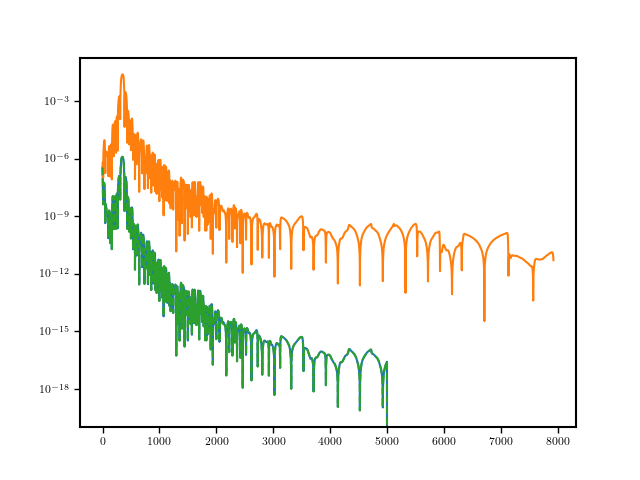

In [265]:
plt.close()

plt.plot(abs(M_mat[0,:]))
plt.plot(abs(windows_deep[2 * bmax : 3 * bmax, 1:lmax_win][0,:]))
plt.plot(abs(windows_deep[2 * bmax : 3 * bmax, 1:lmax_win][0,:]*cl2dl), ls="--")

plt.yscale("log")

plt.show()


In [266]:
np.shape(windows_dict["TT 90x90"])

(40, 7924)

In [271]:
np.shape(np.tile(cl2dl_vec[:40], (7924, 1)))

(7924, 40)

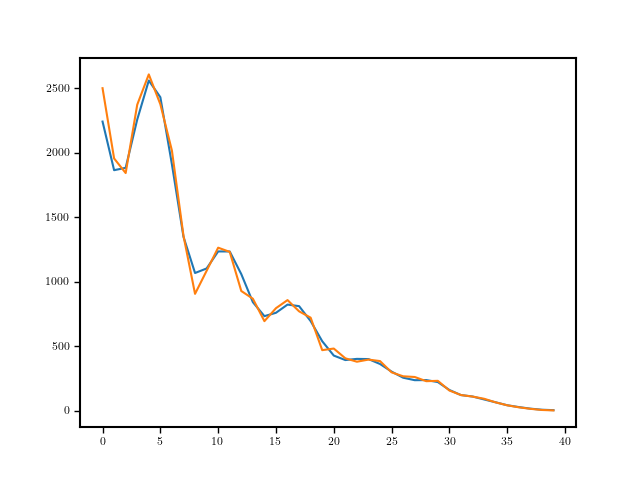

In [291]:
new_window = windows_dict["TT 90x90"] / np.tile(cl2dl_vec[:40], (7924, 1)).T * np.tile(cl2dl, (40, 1))
new_spec = new_window @ modified_theory_Cls[:7924]

plt.close()

plt.plot(new_spec)
plt.plot(spt3g_like.data_bandpowers[:40])

plt.show()


In [292]:
new_spec * cl2dl_vec[:40]

Array([3.90529913e-02, 2.76766084e-02, 2.40995754e-02, 2.51702917e-02,
       2.50870602e-02, 2.11000793e-02, 1.47908203e-02, 9.36978626e-03,
       6.69257696e-03, 6.27085873e-03, 6.39897652e-03, 5.85336646e-03,
       4.61053726e-03, 3.37683197e-03, 2.71826769e-03, 2.61081487e-03,
       2.63112463e-03, 2.41688217e-03, 1.93459522e-03, 1.40448111e-03,
       1.04508473e-03, 9.02730248e-04, 8.70159432e-04, 8.18026638e-04,
       6.99392675e-04, 5.53831840e-04, 4.42756998e-04, 3.88629195e-04,
       3.70636332e-04, 3.22167297e-04, 2.11585594e-04, 1.45630134e-04,
       1.21228317e-04, 8.82302076e-05, 5.82814922e-05, 3.23338010e-05,
       1.84751861e-05, 8.38460475e-06, 2.85262189e-06, 1.08391414e-06],      dtype=float64)

In [97]:
delta_bdp*cl2dl_vec

Array([ 4.40506342e-03,  1.30148914e-03, -5.37175444e-04,  1.27090059e-03,
        4.49521052e-04, -4.99297294e-04,  8.01426602e-04,  4.03348775e-05,
       -1.02179477e-03, -1.07184819e-04,  1.47904173e-04, -1.93180618e-05,
       -5.75305042e-04,  1.03621184e-04, -1.46005903e-04,  1.21562019e-04,
        1.10596071e-04, -1.21257988e-04,  7.31153233e-05, -1.81965983e-04,
        1.32935522e-04,  3.08421196e-05, -4.79523074e-05, -8.34733529e-06,
        4.34084012e-05, -1.07248981e-05,  1.87276377e-05,  4.07287334e-05,
       -1.23797534e-05,  1.41645880e-05, -5.36572141e-06,  9.16996608e-08,
       -7.38290758e-07,  5.59138897e-06, -3.82669658e-07, -2.13332307e-07,
       -1.16446469e-06, -7.11199894e-07, -8.59169554e-07, -6.84212048e-07,
       -1.08869368e-03, -2.64767072e-04, -2.45669330e-04,  4.55073717e-05,
       -6.70640882e-06,  2.09604245e-04, -1.57372999e-04,  2.86097622e-04,
       -1.44261312e-04, -5.73994972e-05, -4.66348688e-05, -7.62512034e-05,
        7.63092001e-05,  

In [84]:
delta_bdp/np.sqrt(np.diag(spt3g_like.covariance))

Array([ 1.42218623e+00,  6.15722745e-01, -2.90499523e-01,  7.40477539e-01,
        2.80943601e-01, -3.86327688e-01,  8.54746463e-01,  6.68532050e-02,
       -2.43406327e+00, -2.90884919e-01,  4.17282379e-01, -6.11436245e-02,
       -2.27980438e+00,  5.49084582e-01, -1.02240026e+00,  8.90113324e-01,
        8.18714355e-01, -1.03407788e+00,  7.83698993e-01, -2.56237144e+00,
        2.52620246e+00,  6.82647106e-01, -1.14348811e+00, -2.18699442e-01,
        1.33871339e+00, -4.04858984e-01,  8.84526668e-01,  2.22932980e+00,
       -7.53233586e-01,  1.47095464e+00, -7.61509929e-01,  1.91898584e-02,
       -1.84675477e-01,  1.70879233e+00, -2.30792433e-01, -1.76349891e-01,
       -1.27520940e+00, -1.37279632e+00, -2.13701489e+00, -2.08355761e+00,
       -1.22687686e+00, -4.31253804e-01, -5.98071924e-01,  1.55216321e-01,
       -2.87597235e-02,  9.91314965e-01, -7.98289113e-01,  1.57748200e+00,
       -9.69918234e-01, -5.50326776e-01, -5.84314540e-01, -1.01696206e+00,
        1.13277061e+00,  

In [80]:
spec_conv = example_spec["ell"]*(example_spec["ell"]+1)/(2*np.pi)
spec_conv = np.tile(spec_conv, 6)
spec_conv_binned = spt3g_like.bin_model_specs(spec_conv)


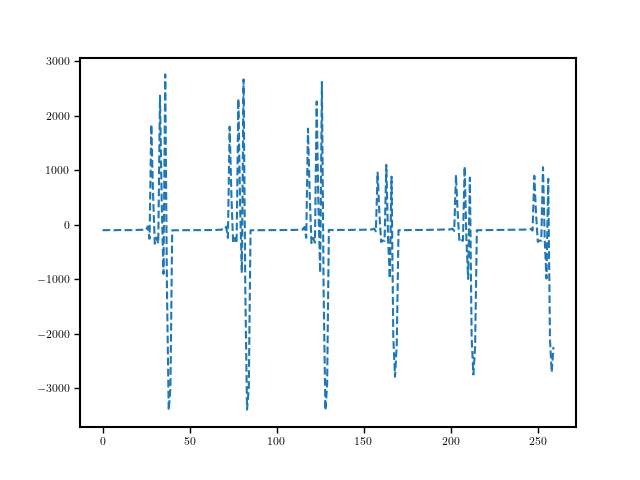

In [32]:
man = spt3g_like.effective_ells * (spt3g_like.effective_ells + 1)/(2*np.pi)

plt.close()

plt.plot(spec_conv_binned-man, ls="--")

plt.show()


In [19]:
chisq

Array(288.25302241, dtype=float64)

In [20]:
# Cl
288.25302241-288.252869629064

0.00015278093604820242

In [79]:
# Dl
288.22922443-288.252869629064

-0.023645199063992095

In [299]:
288.25302241-288.252869629064

0.00015278093604820242

array([1.04719755e+00, 5.23598776e-01, 3.14159265e-01, ...,
       2.51478279e-07, 2.51377688e-07, 2.51277157e-07])

In [30]:
modified_theory_Cls = spt3g_like.get_model_specs(pars_for_like)
binned_theory_Cls = spt3g_like.bin_model_specs(modified_theory_Cls)
delta_bdp = spt3g_like.data_bandpowers - binned_theory_Cls


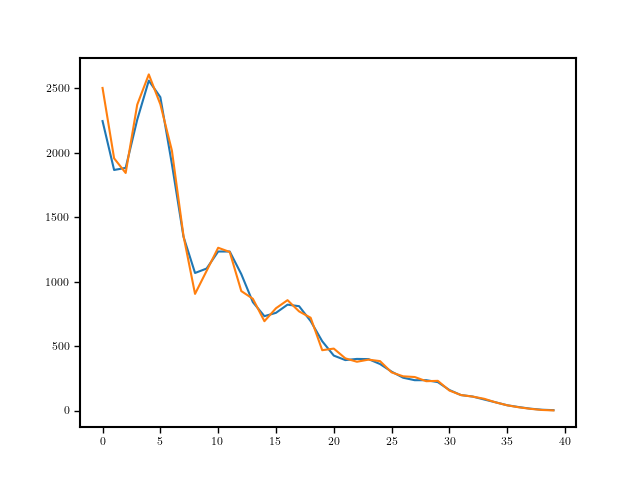

In [31]:
plt.close()

plt.plot(binned_theory_Cls[:40])
plt.plot(spt3g_like.data_bandpowers[:40])

plt.show()


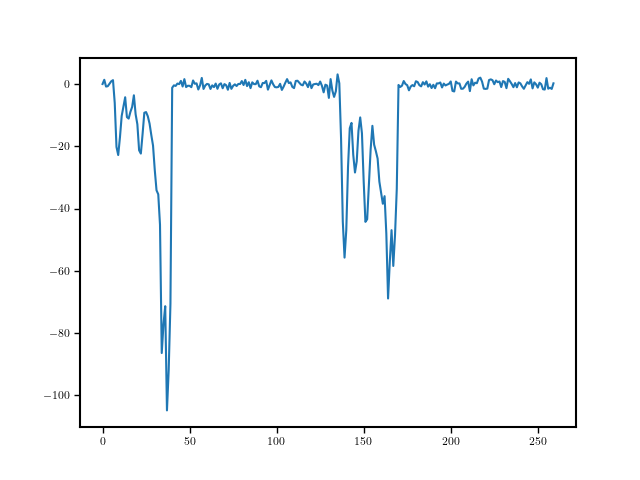

In [15]:
plt.close()

plt.plot(delta_bdp/np.sqrt(np.diag(spt3g_like.covariance)))

plt.show()


In [97]:
chisq

Array(7.14960167e+16, dtype=float64)

# Initialise Theory Code

In [5]:
# Define fiducial parameters - cosmological ones by hand
fid_pars = {'H0': 67.37,
            'ombh2': 0.02233,
            'omch2': 0.1198,
            'logA': 3.043,
            'ns': 0.9652,
            'tau': 0.054}

# Nuisance parameters are set to the central values of their priors
for par_name in spt3g_like.required_nuisance_parameters:
    for prior in spt3g_like.priors:
        if par_name in prior.par_names:
            fid_pars[par_name] = prior.central_value[prior.par_names.index(par_name)]

# Grab a theory calculator and initialise it
# Here, we use our differentiable, high-precision CosmoPower models
# These take care of the step of moving from cosmological parameters to theory Cls
cp_emulator_filenames = {"TT": "cmb_spt_TT_NN",
                         "TE": "cmb_spt_TE_PCAplusNN",
                         "EE": "cmb_spt_EE_NN"}

theory_calc = spt3g_interface.CosmoPowerJAXCalculator(cp_emulator_filenames)


# Calculate $\chi^2$ of Fidual Point

In [6]:
# Calculate CMB theory spectra
fid_CMB_specs = spt3g_tools.pars_to_theory_specs(fid_pars,# Parameter values
                                                 theory_calc,# Theory code
                                                 spt3g_like.N_ell_bins_theory)# ell range

# Prepare dictionary for likelihood
pars_for_like = deepcopy(fid_pars)
pars_for_like["Cls"] = fid_CMB_specs

# Hand off to likelihood and print results
chisq = spt3g_like.chi_square(pars_for_like)
print(f"Chisq for fiducial parameter values: {sigfig.round(float(chisq), decimals=2)}")
print(f"Chisq / dof: {sigfig.round(float(chisq/(len(spt3g_like.data_bandpowers)-6)), decimals=2)}")


Chisq for fiducial parameter values: 149.33
Chisq / dof: 0.96


# Gradient-Based Minimiser

In [7]:
# Here, we grab a function that moves from parameters to logl all in one step.
# This is a light wrapper that combines our theory calculator (CosmoPower) and our likelihood.
# There's a bit of glue in-between, which crops the spectra to the right ell range.
# We also grab the derivative and the Hessian
like = jax.jit(spt3g_interface.get_params_to_logl_func(spt3g_like, theory_calc))
like_deriv = jax.jit(jax.jacfwd(like))
like_hessian = jax.jit(jax.hessian(like))


In [8]:
# Run the minimisers!
# We run a simple Newton-Raphson minimiser 3 times with different starting points.
# Notice how the first one or two evaluations of the hessian and the derivative functions are quite slow.
# This is due to our use of jit() above.
# However, subsequent iterations are much faster, meaning as a whole this saves time.

# We want to minimise all parameters - cosmological ones and nuisance parameters
pars_for_min = ["H0", "ombh2", "omch2", "ns", "logA", "tau"] + spt3g_like.required_nuisance_parameters

# Details of the minimiser algorithm - more small steps lead to better stability
step_size = 0.15
N_newton = 20
N_min = 3

# Set the fiducial starting point
starting_pars = deepcopy(fid_pars)
start_scatter = {"H0": 0.5, "ombh2": 0.00005, "omch2": 0.001, "ns": 0.005}

# Start multiple minimisers
all_eval_points = []
all_eval_par_covs = []
for i_min in range(N_min):
    
    # Add scatter to starting point
    this_starting_pars = deepcopy(starting_pars)
    this_starting_pars, start_box = spt3g_tools.add_uniform_scatter(start_params = this_starting_pars,# fiducial starting point
                                                                    box_width = 5,# inflates the passed parameter errors
                                                                    par_errs = start_scatter,# scale of the scatter
                                                                    seed = i_min)# RNG seed for scatter
        
    # Step through minimiser
    eval_points, eval_par_cov = spt3g_tools.newton_raphson_minimiser(like_deriv = like_deriv,# Derivative function
                                                                     like_hess = like_hessian,# Hessian function
                                                                     starting_pars = this_starting_pars,# Start point
                                                                     pars_for_min = pars_for_min,# Which parameters to minimise
                                                                     N_newton = N_newton,# How many steps to take
                                                                     step_size = step_size,# Scaling of the step size
                                                                     show_progress = True)# Show loading bars
    
    # Increment
    all_eval_points.append(eval_points)
        
    all_eval_par_covs.append(eval_par_cov)
    print(f"Finished minimiser: {i_min}")


  0%|          | 0/20 [00:00<?, ?it/s]

Finished minimiser: 0


  0%|          | 0/20 [00:00<?, ?it/s]

Finished minimiser: 1


  0%|          | 0/20 [00:00<?, ?it/s]

Finished minimiser: 2


In [9]:
# Analyse the minimisers and check convergence
# This is actually the first time we evaluate the log likelihood itself
# (we only accessed its derivate and Hessian before), so we have a little jit delay here too
min_logl = np.array([like(all_eval_points[i_min][-1]) for i_min in range(N_min)])
min_spread = np.amax(min_logl)-np.amin(min_logl)
min_ix = np.argmax(min_logl)

print(f"{N_min} minimisers agree to within {sigfig.round(float(min_spread), decimals=4)}")
print(f"Best minimiser index: {min_ix}")


3 minimisers agree to within 0.0407
Best minimiser index: 2


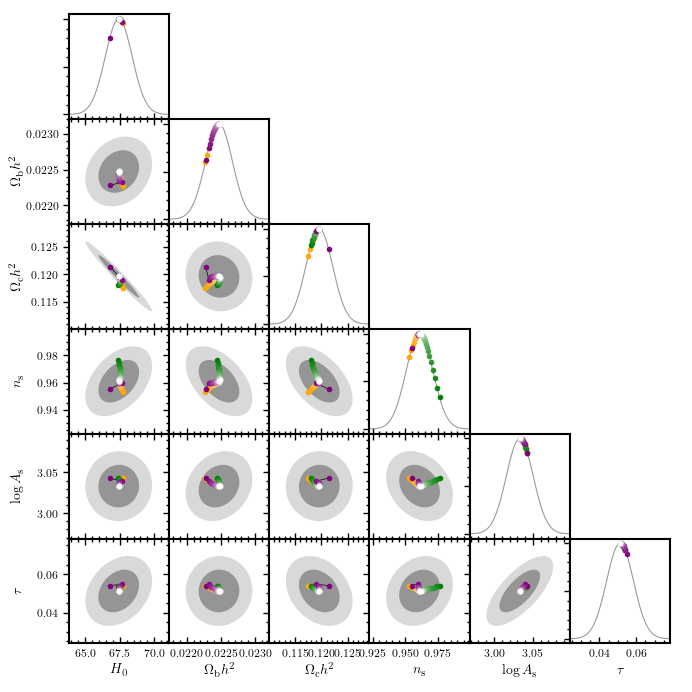

In [10]:
# Make a triangle plot and trace the journey of the minimiser!
# Here we plot the trajectories the three minimisers take.
# We also show expected parameter errors based on the Hessian, which gives the problem some scale.
# Since the Hessian is already computed for the minimiser, we can re-use it.
# Note though, that we are assuming here that parameter posteriors are Gaussian, i.e. the Fisher matrix
# captures everything. That's not always the case (and the reason we run chains), but for LCDM, this
# is close enough!

# Only plot cosmological parameters
pars_to_plot = ["H0", "ombh2", "omch2", "ns", "logA", "tau"]

plt.close()

# Plot parameters
sigma_plot_range = 3
sigma_levels = 2

ax = spt3g_plots.triangle_plot_from_cov(pars_to_plot = pars_to_plot,# which parameters to plot
                                        bf_point = all_eval_points[min_ix][-1],# the best-fit point
                                        par_cov = all_eval_par_covs[min_ix][-1],# the parameter covariance matrix
                                        pars_in_cov = pars_for_min,# the order of parameters in the covariance
                                        sigma_plot_range = sigma_plot_range,# sets the axes limits
                                        sigma_levels = sigma_levels)# how many sigma levels to plot

# Loop over the three minimisers and show their paths with different colours.
# The trajectories start out in full colour, but get progressively lighter.
# Final points of the minimisers are shown in white.
for i_min, colour in zip(range(N_min),
                         ["orange", "green", "purple"]):
    
    spt3g_plots.add_min_trajectory(ax = ax,# axis instance
                                   pars_to_plot = pars_to_plot,# which parameters to plot
                                   eval_points = all_eval_points[i_min],# a list of all the points in the minimiser trajectory
                                   par_cov = all_eval_par_covs[min_ix][-1],# covariance of the best run - this is used to set the correct height in the 1d panels
                                   pars_in_cov = pars_for_min,# the order of parameters in the covariance
                                   bf_point = all_eval_points[min_ix][-1],# the best-fit point - again used in the 1d panels
                                   base_colour = colour,# the base colour used to show the trajectory path
                                   markeredgewidth = 0)# no black outline around points

plt.tight_layout()

plt.show()


# Run Cobaya Chains

In [11]:
# Wrap the likelihood for cobaya.
# This function returns a subclass of cobaya.likelihood.Likelihood with our likelihood pasted in,
# as well as all its requirements.
cobaya_info = {}
cobaya_info["likelihood"] = spt3g_interface.get_cobaya_info_dict_for_like(spt3g_like, "spt3g_example_like")

# Prepare the remainder of the info dictionary for Cobaya.
# This code is adapted from cobaya's input generator program.
# More information on the format etc. on the Cobaya website.
cobaya_info["params"] = {'H0': {'latex': 'H_0',
                                'prior': {'max': 80, 'min': 55},
                                'proposal': 1.0},
                         'logA': {'latex': '\\log(10^{10} A_\\mathrm{s})',
                                  'prior': {'max': 3.2, 'min': 2.7},
                                  'proposal': 0.005},
                         'ns': {'latex': 'n_\\mathrm{s}',
                                'prior': {'max': 1.13, 'min': 0.868},
                                'proposal': 0.01},
                         'ombh2': {'latex': '\\Omega_\\mathrm{b} h^2',
                                   'prior': {'max': 0.026, 'min': 0.018},
                                   'proposal': 0.00015},
                         'omch2': {'latex': '\\Omega_\\mathrm{c} h^2',
                                   'prior': {'max': 0.16, 'min': 0.09},
                                   'proposal': 0.0025},
                         'tau': {'latex': '\\tau_\\mathrm{reio}',
                                 'prior': {'max': 0.09, 'min': 0.018},
                                 'proposal': 0.005}}
           
cobaya_info["theory"] = {'cosmopower': {'external': theory_calc,
                                        'stop_at_error': True}}

cobaya_info["sampler"] = {'mcmc': {'drag': False,
                                   'oversample_power': 0.5,
                                   'proposal_scale': 2.0,
                                   'max_samples': 3000}}


In [12]:
# Continue preparing Cobaya.
# * Add the nuisance parameters to the sampled parameters block
# * Add nuisance parameters (and tau) to the required parameters for the likelihood
#     * This is because our priors built into the likelihood, rather than going through Cobaya's prior implementation

# Add nuisance parameters to Cobaya
for par_name in spt3g_like.required_nuisance_parameters:
    for prior in spt3g_like.priors:
        if par_name in prior.par_names:
            
            # Grab the prior central value and width
            prior_central_val = float(prior.central_value[prior.par_names.index(par_name)])
            prior_width = np.sqrt(np.diag(prior.prior_covariance)[prior.par_names.index(par_name)])
            
            # Add to Cobaya's parameters
            cobaya_info["params"][par_name] = {'prior':
                                               {'min': prior_central_val-10*prior_width,
                                                'max': prior_central_val+10*prior_width},
                                               'ref': float(eval_points[-1][par_name]),
                                               'proposal': prior_width,
                                               'latex': par_name}
        
# Add priors and nuisance parameters as required parameters to the likelihood
for par in spt3g_like.required_prior_parameters + spt3g_like.required_nuisance_parameters:
    cobaya_info["likelihood"]["spt3g_example_like"]["requires"][par] = None


In [13]:
# Headstart for chains: start from previously found bf point and covariance matrix
for par_name in all_eval_points[min_ix][-1]:
    cobaya_info["params"][par_name]["ref"] = float(all_eval_points[min_ix][-1][par_name])

cobaya_info["sampler"]["mcmc"]['covmat'] = all_eval_par_covs[min_ix][-1]
cobaya_info["sampler"]["mcmc"]['covmat_params'] = pars_for_min


In [14]:
# We now run Cobaya's Metropolis-Hastings sampler until we get 3k accepted samples.
# This takes approximately 1min. minutes on a laptop.
updated_info, sampler = run(cobaya_info)


[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {spt3g_example_like: 526.0, SPT3G_JAX_interface_tools.CosmoPowerJAXCalculator: 41.5}
[mcmc] Initial point: H0:67.42375, logA:3.033137, ns:0.960981, ombh2:0.02247221, omch2:0.1195876, tau:0.05122778, EE_Poisson_150x150:0.01050474, EE_PolGalDust_Alpha:-2.42, EE_PolGalDust_Amp:0.04180161, EE_PolGalDust_Beta:1.51, Ecal150:0.9967435, Kappa:-1.033979e-05, TE_PolGalDust_Alpha:-2.42, TE_PolGalDust_Amp:0.1071956, TE_PolGalDust_Beta:1.51, TT_CIBClustering_Alpha:0.8, TT_CIBClustering_Amp:3.576413, TT_CIBClustering_Beta:2.260182, TT_GalCirrus_Alpha:-2.529668, TT_GalCirrus_Amp:1.884426, TT_GalCirrus_Beta:1.48, TT_Poisson_150x150:14.60695, TT_kSZ_Amp:4.087189, TT_tSZ_Amp:3.971495, Tcal150:0.9996689
[mcmc] Oversampling with factors:
[mcmc] * 1 : ['H0', 'logA', 'ns', 'ombh2', 'omch2', 'tau']
[mcmc] * 3 : ['EE_Poisson_150x150', 'EE_PolGalDust

In [15]:
# Cast Cobaya samples into getdist object holding the same information.
# The outlier fraction warning appears, because we have few samples.
gd_samples = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])


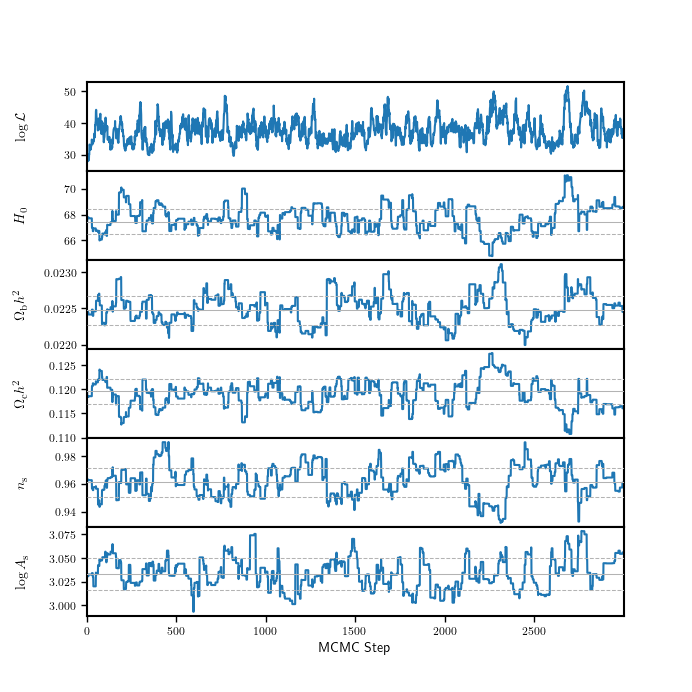

In [16]:
# Plot the samples of the MCMC chain.
# Only focus on cosmological parmeters here and the log likelihood.
# Also indicate the best-fit point found previously and the 1 sigma limits from the evaluation of the Hessian
# (assumes the posteriors are Gaussian, which for this data set and LCDM is a decent approximation).

plt.close()

fig, ax = spt3g_plots.plot_mcmc_chain_steps(gd_samples,# samples to plot
                                            ["H0", "ombh2", "omch2", "ns", "logA"],# parameters to plot
                                            all_eval_points[min_ix][-1],# best-fit point
                                            all_eval_par_covs[min_ix][-1],# Fisher matrix from the Hessian at the best-fit point
                                            pars_for_min)# Order of paramters in the Fisher matrix

plt.show()
